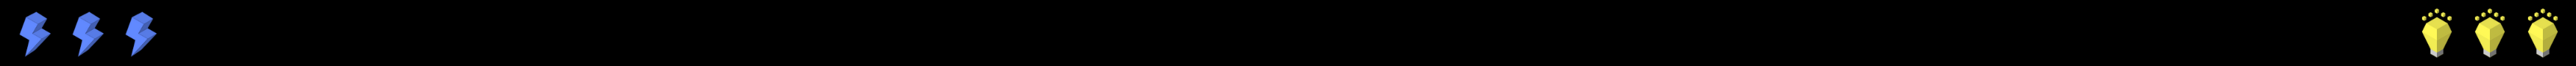

#### Import Packages.

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import glob
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from typing import Union
from itertools import product
from tqdm.notebook import tqdm
from statsmodels.stats.diagnostic import acorr_ljungbox
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")

#### Data.

In [2]:
%%time
df1 = pd.read_excel("Data/2017-2018.xlsx")
df2 = pd.read_excel("Data/2019-2020.xlsx")
df3 = pd.read_excel("Data/2021-2022.xlsx")
df4 = pd.read_excel("Data/2023-2024.xlsx")

CPU times: total: 4.09 s
Wall time: 4.37 s


In [3]:
df1.head()

,Year,Date,Hourly Demand Met (in MW)
0,2018,01-Jan 12am,112591.48
1,2018,01-Jan 1am,109660.41
2,2018,01-Jan 2am,107696.63
3,2018,01-Jan 3am,106847.56
4,2018,01-Jan 4am,108517.07


In [4]:
file_paths = glob.glob("Data/*.xlsx")
dataframes = [pd.read_excel(file) for file in file_paths]
combined_data = pd.concat(dataframes, ignore_index=True)

In [5]:
dataset = combined_data

In [6]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64248 entries, 0 to 64247
Data columns (total 3 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Year                       64248 non-null  int64  
 1   Date                       64248 non-null  object 
 2   Hourly Demand Met (in MW)  64248 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 1.5+ MB


In [7]:
dataset['Timestamp'] = dataset['Year'].astype(str) + "-" + dataset['Date'].astype(str)

In [8]:
dataset.head()

,Year,Date,Hourly Demand Met (in MW),Timestamp
0,2018,01-Jan 12am,112591.48,2018-01-Jan 12am
1,2018,01-Jan 1am,109660.41,2018-01-Jan 1am
2,2018,01-Jan 2am,107696.63,2018-01-Jan 2am
3,2018,01-Jan 3am,106847.56,2018-01-Jan 3am
4,2018,01-Jan 4am,108517.07,2018-01-Jan 4am


In [9]:
dataset = dataset.drop(columns = ['Year', 'Date'])

In [10]:
dataset['Timestamp'] = pd.to_datetime(dataset['Timestamp'])
dataset.dtypes

Hourly Demand Met (in MW)           float64
Timestamp                    datetime64[ns]
dtype: object

In [11]:
dataset.duplicated().sum()

np.int64(0)

In [12]:
dataset.shape

(64248, 2)

In [13]:
max_timestamp = dataset['Timestamp'].max()
min_timestamp = dataset['Timestamp'].min()
max_timestamp, min_timestamp

(Timestamp('2024-04-30 23:00:00'), Timestamp('2017-01-01 00:00:00'))

In [14]:
custom_timestamp = pd.date_range(start = min_timestamp, end = max_timestamp, freq = 'h')
custom_timestamp = pd.DataFrame(custom_timestamp, columns = ['Timestamp'])
custom_timestamp

,Timestamp
0,2017-01-01 00:00:00
1,2017-01-01 01:00:00
2,2017-01-01 02:00:00
3,2017-01-01 03:00:00
4,2017-01-01 04:00:00
...,...
64243,2024-04-30 19:00:00
64244,2024-04-30 20:00:00
64245,2024-04-30 21:00:00
64246,2024-04-30 22:00:00


In [15]:
dataset = custom_timestamp.merge(dataset, on = 'Timestamp', how = 'left')
dataset.shape

(64248, 2)

In [16]:
dataset.head()

,Timestamp,Hourly Demand Met (in MW)
0,2017-01-01 00:00:00,108985.17
1,2017-01-01 01:00:00,105856.08
2,2017-01-01 02:00:00,103115.75
3,2017-01-01 03:00:00,102407.04
4,2017-01-01 04:00:00,104235.34


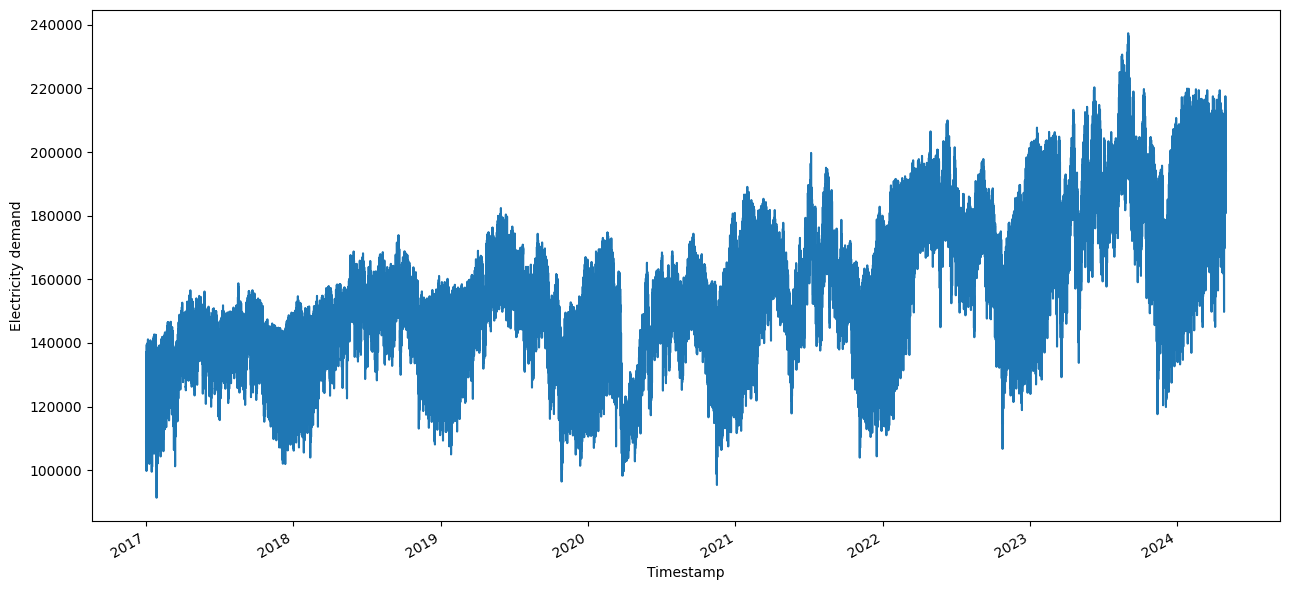

In [17]:
fig, ax = plt.subplots(figsize=(13,6))

ax.plot(dataset['Timestamp'], dataset['Hourly Demand Met (in MW)'])
ax.set_xlabel('Timestamp')
ax.set_ylabel('Electricity demand')

fig.autofmt_xdate()
plt.tight_layout()

#### Start with baseline model on sample data.

In [18]:
baseline_train = dataset[:1000]
baseline_test = dataset[1000:1100]

In [19]:
historical_baseline_mean = baseline_train['Hourly Demand Met (in MW)'].mean()
historical_baseline_mean

np.float64(124990.46753)

In [20]:
baseline_test = baseline_test.copy()
baseline_test.loc[:, 'pred_mean'] = historical_baseline_mean
baseline_test

,Timestamp,Hourly Demand Met (in MW),pred_mean
1000,2017-02-11 16:00:00,132049.67,124990.46753
1001,2017-02-11 17:00:00,132699.66,124990.46753
1002,2017-02-11 18:00:00,136494.41,124990.46753
1003,2017-02-11 19:00:00,139043.27,124990.46753
1004,2017-02-11 20:00:00,132069.83,124990.46753
...,...,...,...
1095,2017-02-15 15:00:00,132542.36,124990.46753
1096,2017-02-15 16:00:00,133728.64,124990.46753
1097,2017-02-15 17:00:00,134944.64,124990.46753
1098,2017-02-15 18:00:00,139884.54,124990.46753


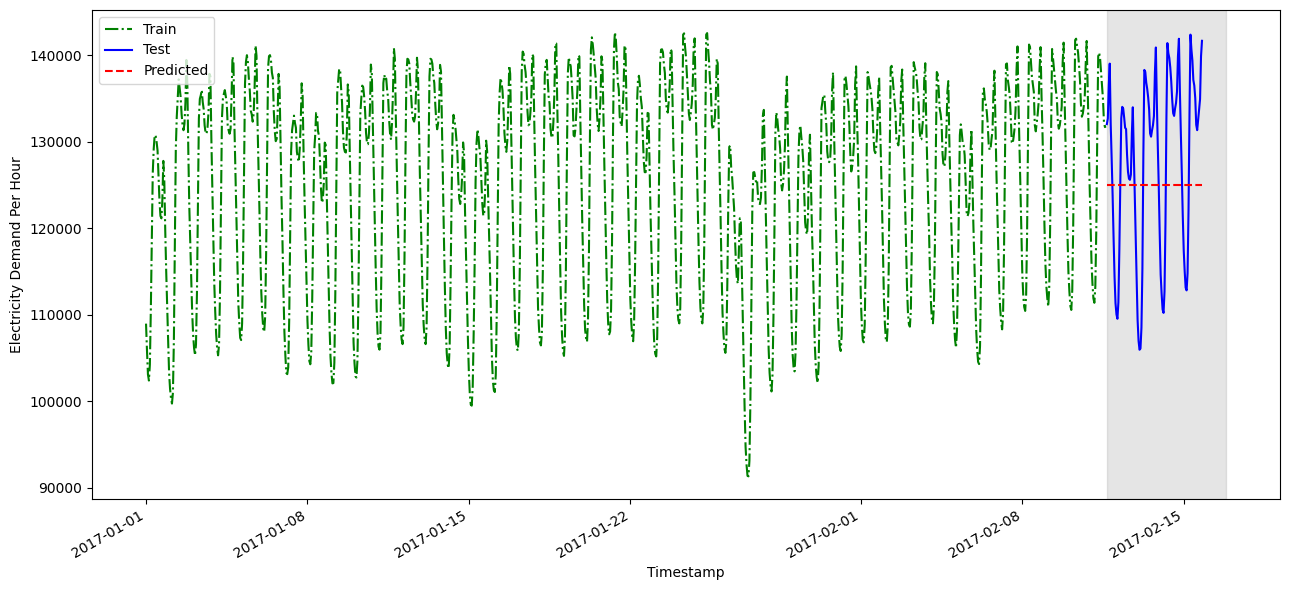

In [21]:
fig, ax = plt.subplots(figsize = (13, 6))
ax.plot(baseline_train['Timestamp'], baseline_train['Hourly Demand Met (in MW)'], 'g-.', label='Train')
ax.plot(baseline_test['Timestamp'], baseline_test['Hourly Demand Met (in MW)'], 'b-', label='Test')
ax.plot(baseline_test['Timestamp'], baseline_test['pred_mean'], 'r--', label='Predicted')
ax.set_xlabel('Timestamp')
ax.set_ylabel('Electricity Demand Per Hour')
ax.axvspan(pd.Timestamp('2017-02-11 16:00:00'), pd.Timestamp('2017-02-16 20:00:00'), color='#808080', alpha=0.2)
ax.legend(loc=2)
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

In [22]:
def mape(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred) / y_true)

In [23]:
baseline_mape = mape(baseline_test['Hourly Demand Met (in MW)'], baseline_test['pred_mean'])
baseline_mape

np.float64(0.07498243852962791)

In [24]:
historical_lasthours_mean = baseline_train.loc[976 : 1000, 'Hourly Demand Met (in MW)'].mean()
historical_lasthours_mean

np.float64(129391.76291666667)

In [25]:
baseline_test.loc[:, 'lasthours_pred_mean'] = historical_lasthours_mean
baseline_test

,Timestamp,Hourly Demand Met (in MW),pred_mean,lasthours_pred_mean
1000,2017-02-11 16:00:00,132049.67,124990.46753,129391.762917
1001,2017-02-11 17:00:00,132699.66,124990.46753,129391.762917
1002,2017-02-11 18:00:00,136494.41,124990.46753,129391.762917
1003,2017-02-11 19:00:00,139043.27,124990.46753,129391.762917
1004,2017-02-11 20:00:00,132069.83,124990.46753,129391.762917
...,...,...,...,...
1095,2017-02-15 15:00:00,132542.36,124990.46753,129391.762917
1096,2017-02-15 16:00:00,133728.64,124990.46753,129391.762917
1097,2017-02-15 17:00:00,134944.64,124990.46753,129391.762917
1098,2017-02-15 18:00:00,139884.54,124990.46753,129391.762917


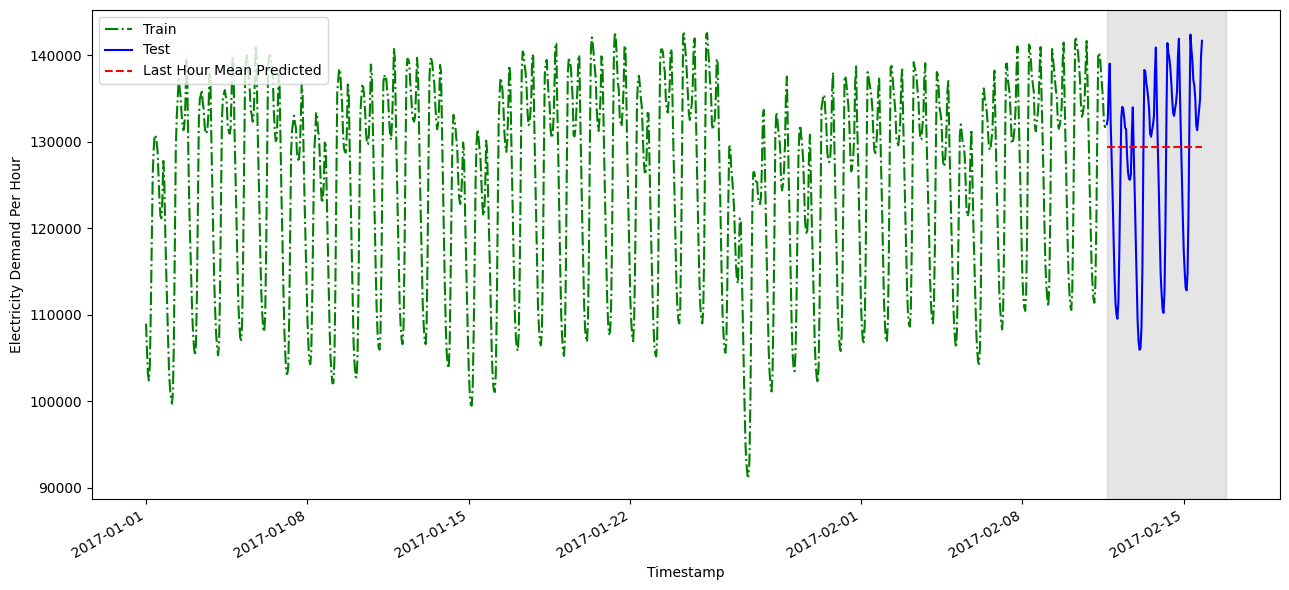

In [26]:
fig, ax = plt.subplots(figsize = (13, 6))
ax.plot(baseline_train['Timestamp'], baseline_train['Hourly Demand Met (in MW)'], 'g-.', label='Train')
ax.plot(baseline_test['Timestamp'], baseline_test['Hourly Demand Met (in MW)'], 'b-', label='Test')
# ax.plot(baseline_test['Timestamp'], baseline_test['pred_mean'], 'r--', label='Mean Predicted')
ax.plot(baseline_test['Timestamp'], baseline_test['lasthours_pred_mean'], 'r--', label='Last Hour Mean Predicted')
ax.set_xlabel('Timestamp')
ax.set_ylabel('Electricity Demand Per Hour')
ax.axvspan(pd.Timestamp('2017-02-11 16:00:00'), pd.Timestamp('2017-02-16 20:00:00'), color='#808080', alpha=0.2)
ax.legend(loc=2)
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

In [27]:
baseline_lasthour_mape = mape(baseline_test['Hourly Demand Met (in MW)'], baseline_test['lasthours_pred_mean'])
baseline_lasthour_mape

np.float64(0.06876529206715612)

In [28]:
baseline_test.loc[:, 'lasthours_pred_season'] = baseline_train['Hourly Demand Met (in MW)'][900 : 1000].values
baseline_test

,Timestamp,Hourly Demand Met (in MW),pred_mean,lasthours_pred_mean,lasthours_pred_season
1000,2017-02-11 16:00:00,132049.67,124990.46753,129391.762917,132881.66
1001,2017-02-11 17:00:00,132699.66,124990.46753,129391.762917,129955.84
1002,2017-02-11 18:00:00,136494.41,124990.46753,129391.762917,129805.65
1003,2017-02-11 19:00:00,139043.27,124990.46753,129391.762917,130597.44
1004,2017-02-11 20:00:00,132069.83,124990.46753,129391.762917,131610.99
...,...,...,...,...,...
1095,2017-02-15 15:00:00,132542.36,124990.46753,129391.762917,136423.18
1096,2017-02-15 16:00:00,133728.64,124990.46753,129391.762917,134859.44
1097,2017-02-15 17:00:00,134944.64,124990.46753,129391.762917,132199.44
1098,2017-02-15 18:00:00,139884.54,124990.46753,129391.762917,131707.65


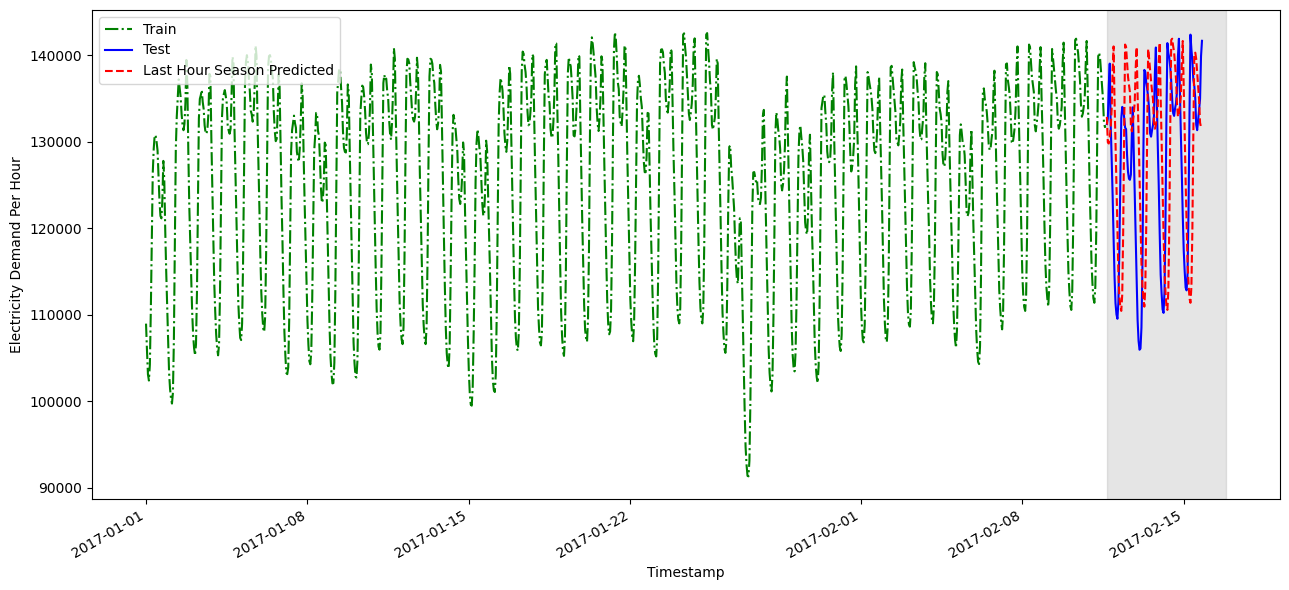

In [29]:
fig, ax = plt.subplots(figsize = (13, 6))
ax.plot(baseline_train['Timestamp'], baseline_train['Hourly Demand Met (in MW)'], 'g-.', label='Train')
ax.plot(baseline_test['Timestamp'], baseline_test['Hourly Demand Met (in MW)'], 'b-', label='Test')
# ax.plot(baseline_test['Timestamp'], baseline_test['pred_mean'], 'r--', label='Mean Predicted')
# ax.plot(baseline_test['Timestamp'], baseline_test['lasthours_pred_mean'], 'r--', label='Last Hour Mean Predicted')
ax.plot(baseline_test['Timestamp'], baseline_test['lasthours_pred_season'], 'r--', label='Last Hour Season Predicted')
ax.set_xlabel('Timestamp')
ax.set_ylabel('Electricity Demand Per Hour')
ax.axvspan(pd.Timestamp('2017-02-11 16:00:00'), pd.Timestamp('2017-02-16 20:00:00'), color='#808080', alpha=0.2)
ax.legend(loc=2)
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

In [30]:
baseline_lastseason_mape = mape(baseline_test['Hourly Demand Met (in MW)'], baseline_test['lasthours_pred_season'])
baseline_lastseason_mape

np.float64(0.08774178669139139)

In [31]:
baseline_mape, baseline_lasthour_mape, baseline_lastseason_mape

(np.float64(0.07498243852962791),
 np.float64(0.06876529206715612),
 np.float64(0.08774178669139139))

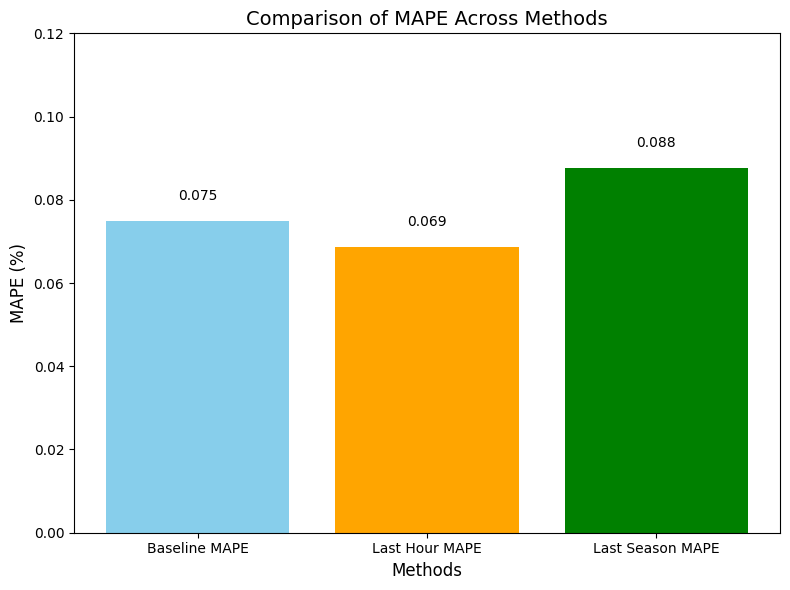

In [32]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))

x = ['Baseline MAPE', 'Last Hour MAPE', 'Last Season MAPE']  # Fixed duplicate label
y = [baseline_mape, baseline_lasthour_mape, baseline_lastseason_mape]

# Create a bar plot
ax.bar(x, y, color=['skyblue', 'orange', 'green'])
ax.set_xlabel('Methods', fontsize=12)
ax.set_ylabel('MAPE (%)', fontsize=12)
ax.set_ylim(0, 0.12)  # Adjust the y-axis limit as needed
ax.set_title('Comparison of MAPE Across Methods', fontsize=14)

# Annotate the bar plot with values
for index, value in enumerate(y):
    ax.text(x=index, y=value + 0.005, s=f"{value:.2}", ha='center', fontsize=10)  # Corrected formatting

plt.tight_layout()
plt.show()

In [33]:
MA_dataset = dataset['Hourly Demand Met (in MW)'][0:1101]

In [34]:
MA_dataset = MA_dataset.values
ADF_result = adfuller(MA_dataset)
print(f'ADF Statistics: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistics: -1.8957552048381892
p-value: 0.33406062378881873


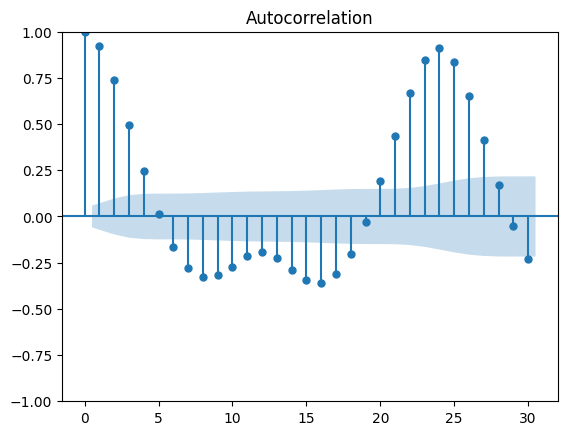

In [35]:
plot_acf(MA_dataset, lags = 30)
plt.show()

In [36]:
MA_dataset_diff = np.diff(MA_dataset, n = 1)
ADF_result = adfuller(MA_dataset_diff)
print(f'ADF Statistics: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistics: -10.654258375917298
p-value: 4.577247727960203e-19


In [37]:
MA_dataset_diff = pd.DataFrame({'Hourly Demand Met (in MW) diff' : MA_dataset_diff})
MA_dataset_diff.shape

(1100, 1)

In [38]:
MA_train_diff = MA_dataset_diff[:1000] 
MA_test_diff = MA_dataset_diff[1000:]

In [72]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon

    if  method == 'mean':
        pred_mean = []
        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))
        return pred_mean

    elif method == 'last':
        pred_last_value = []
        for i in range(train_len, total_len, window):
            mean = df[:i].iloc[-1].values[0]
            pred_last_value.extend(mean for _ in range(window))
        return pred_last_value

    elif method == 'MA':
        pred_MA = []
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order = (0, 0, 3))
            res = model.fit(disp = False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_MA.extend(oos_pred)
        return pred_MA    

    elif method == 'AR':
        pred_AR = []
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(25,0,0))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_AR.extend(oos_pred)
        return pred_AR

    elif method == 'ARMA':
        pred_ARMA = []
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(24,0,8))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_ARMA.extend(oos_pred)
        return pred_ARMA

In [40]:
pred_df = MA_test_diff.copy()
TRAIN_LEN = len(MA_train_diff)
HORIZON = len(MA_test_diff)
WINDOW = 1

pred_mean = rolling_forecast(MA_dataset_diff, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(MA_dataset_diff, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_MA = rolling_forecast(MA_dataset_diff, TRAIN_LEN, HORIZON, WINDOW, 'MA')

In [41]:
pred_df['pred_mean'] = pred_mean
pred_df['pred_last_value'] = pred_last_value
pred_df['pred_MA'] = pred_MA
pred_df.head()

,Hourly Demand Met (in MW) diff,pred_mean,pred_last_value,pred_MA
1000,649.99,23.064500,246.53,177.581668
1001,3794.75,23.690799,649.99,539.360638
1002,2548.86,27.454331,3794.75,4193.832489
1003,-6973.44,29.968195,2548.86,515.646830
1004,-4028.92,22.992689,-6973.44,-9131.397540


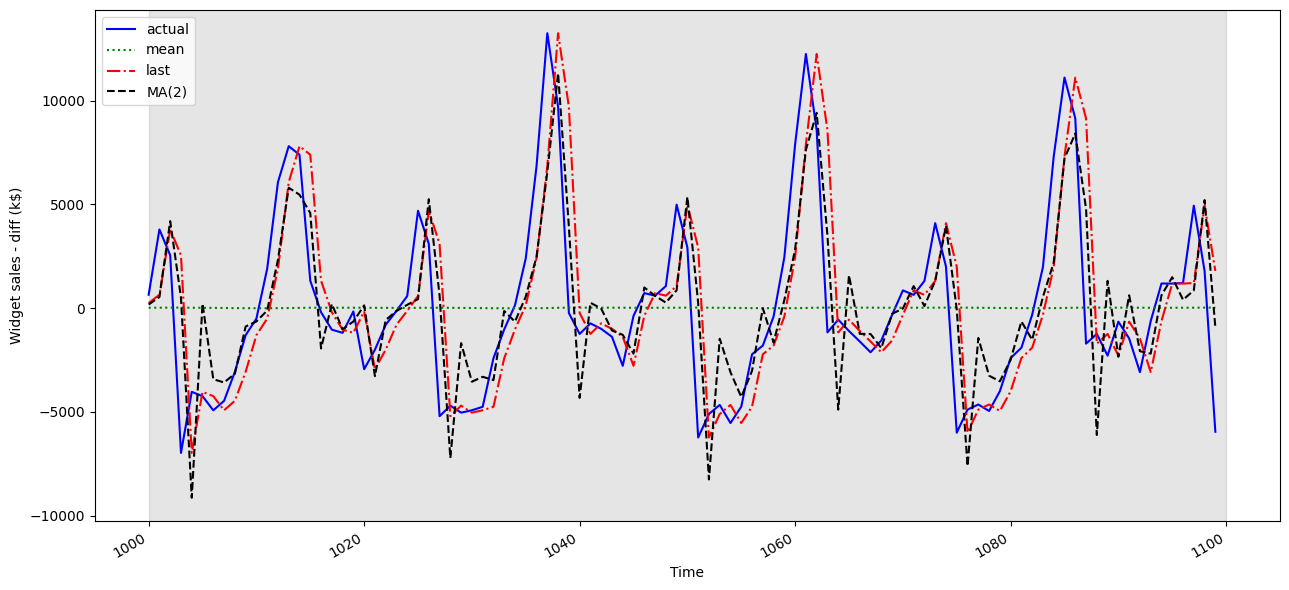

In [42]:
fig, ax = plt.subplots(figsize = (13, 6))

# ax.plot(MA_dataset_diff['Hourly Demand Met (in MW) diff'])
ax.plot(pred_df['Hourly Demand Met (in MW) diff'], 'b-', label='actual')
ax.plot(pred_df['pred_mean'], 'g:', label='mean')
ax.plot(pred_df['pred_last_value'], 'r-.', label='last')
ax.plot(pred_df['pred_MA'], 'k--', label='MA(2)')

ax.legend(loc=2)

ax.set_xlabel('Time')
ax.set_ylabel('Widget sales - diff (k$)')

ax.axvspan(1000, 1100, color='#808080', alpha=0.2)

fig.autofmt_xdate()
plt.tight_layout()

In [43]:
mse_mean = mean_squared_error(pred_df['Hourly Demand Met (in MW) diff'], pred_df['pred_mean'])
mse_last = mean_squared_error(pred_df['Hourly Demand Met (in MW) diff'], pred_df['pred_last_value'])
mse_MA = mean_squared_error(pred_df['Hourly Demand Met (in MW) diff'], pred_df['pred_MA'])
print(mse_mean, mse_last, mse_MA)

18270836.92975346 11195406.719030999 8152415.590296984


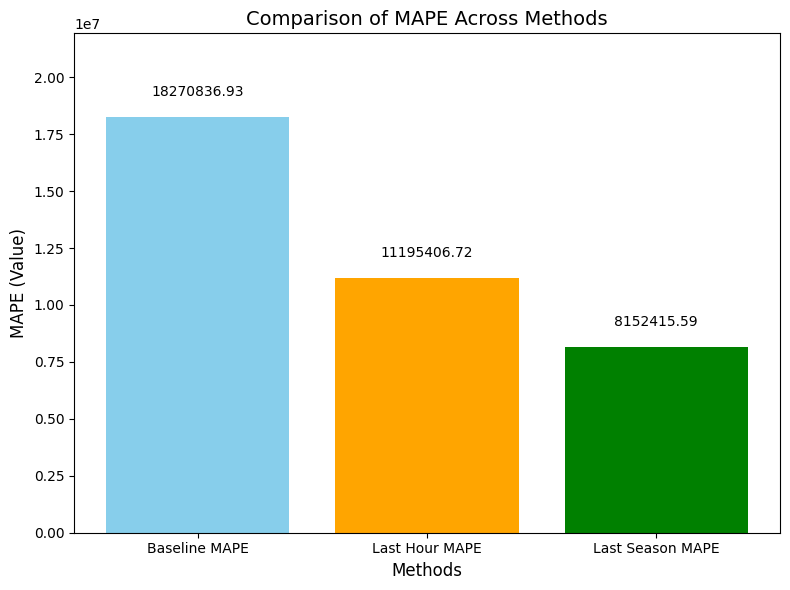

In [44]:
# Initialize plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))

# Data for the plot
x = ['Baseline MAPE', 'Last Hour MAPE', 'Last Season MAPE']
y = [mse_mean, mse_last, mse_MA]

# Create a bar plot
ax.bar(x, y, color=['skyblue', 'orange', 'green'])
ax.set_xlabel('Methods', fontsize=12)
ax.set_ylabel('MAPE (Value)', fontsize=12)
ax.set_ylim(0, max(y) * 1.2)  # Dynamically set y-axis limit
ax.set_title('Comparison of MAPE Across Methods', fontsize=14)

# Annotate the bar plot with values
for index, value in enumerate(y):
    ax.text(index, value + (max(y) * 0.05), s=f"{value:.2f}", ha='center', fontsize=10)

# Adjust layout and show plot
plt.tight_layout()
plt.show()

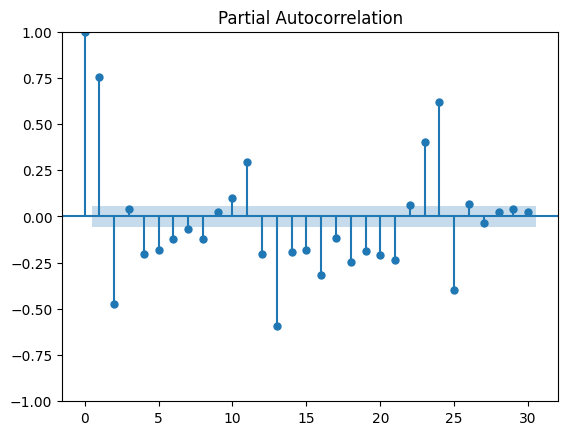

In [45]:
plot_pacf(MA_dataset_diff, lags = 30)
plt.show()

In [46]:
pred_AR = rolling_forecast(MA_dataset_diff, TRAIN_LEN, HORIZON, WINDOW, 'AR')

In [50]:
pred_df['pred_AR'] = pred_AR
pred_df.head()

,Hourly Demand Met (in MW) diff,pred_mean,pred_last_value,pred_MA,pred_AR
1000,649.99,23.064500,246.53,177.581668,1074.426401
1001,3794.75,23.690799,649.99,539.360638,3766.858186
1002,2548.86,27.454331,3794.75,4193.832489,2566.126549
1003,-6973.44,29.968195,2548.86,515.646830,-4838.635282
1004,-4028.92,22.992689,-6973.44,-9131.397540,-6225.871023


In [48]:
mse_AR = mean_squared_error(pred_df['Hourly Demand Met (in MW) diff'], pred_df['pred_AR'])
mse_AR

np.float64(874029.3578130299)

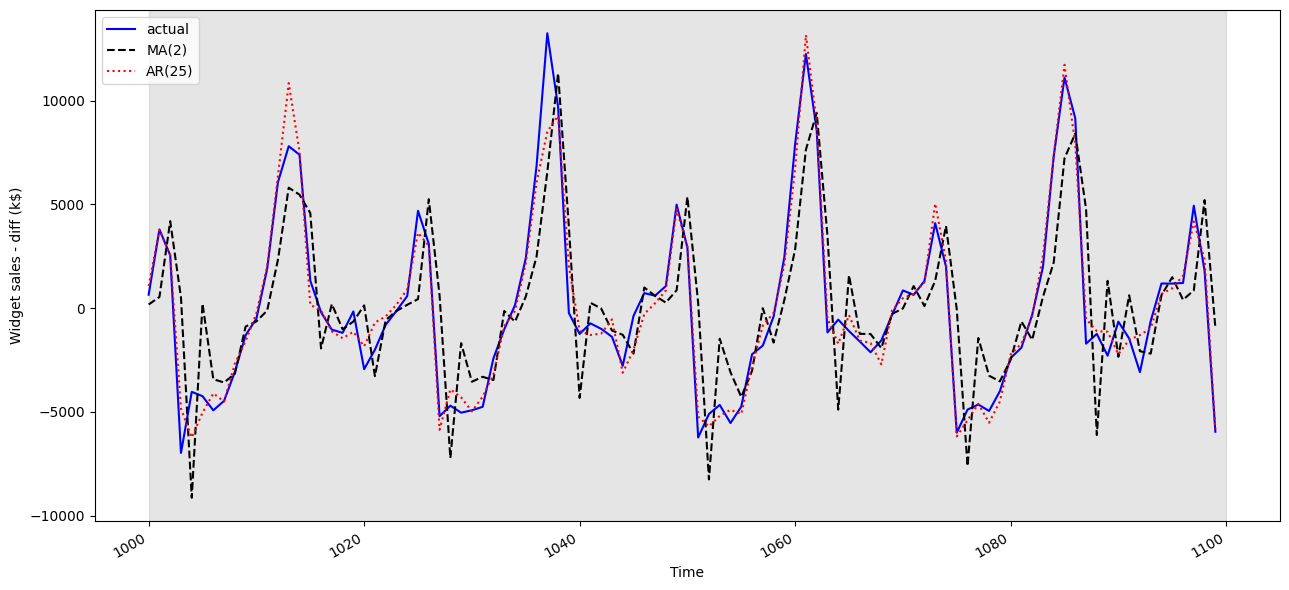

In [51]:
fig, ax = plt.subplots(figsize = (13, 6))

# ax.plot(MA_dataset_diff['Hourly Demand Met (in MW) diff'])
ax.plot(pred_df['Hourly Demand Met (in MW) diff'], 'b-', label='actual')
# ax.plot(pred_df['pred_mean'], 'g:', label='mean')
# ax.plot(pred_df['pred_last_value'], 'r-.', label='last')
ax.plot(pred_df['pred_MA'], 'k--', label='MA(2)')
ax.plot(pred_df['pred_AR'], 'r:', label='AR(25)')

ax.legend(loc=2)

ax.set_xlabel('Time')
ax.set_ylabel('Widget sales - diff (k$)')

ax.axvspan(1000, 1100, color='#808080', alpha=0.2)

fig.autofmt_xdate()
plt.tight_layout()

In [60]:
def optimize_ARMA(endog: Union[pd.Series, list], order_list: list) -> pd.DataFrame:
    results = []
    for order in tqdm(order_list):
        try:
            model = SARIMAX(endog, order=(order[0], 0, order[1]), simple_differencing=False).fit(disp=False)
        except:
            continue
        aic = model.aic
        results.append([order, aic])
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    return result_df

In [77]:
ps = range(0, 25, 1)
qs = range(0, 12, 1)
order_list = list(product(ps, qs))
# order_list

In [61]:
result_df = optimize_ARMA(MA_train_diff, order_list)
result_df

  0%|          | 0/300 [00:00<?, ?it/s]

,"(p,q)",AIC
0,"(24, 8)",16322.794046
1,"(24, 2)",16323.415442
2,"(24, 1)",16323.473609
3,"(24, 11)",16323.946095
4,"(24, 5)",16325.017462
...,...,...
294,"(0, 1)",18855.231838
295,"(0, 9)",18876.597098
296,"(0, 11)",18882.919267
297,"(0, 10)",18906.060293


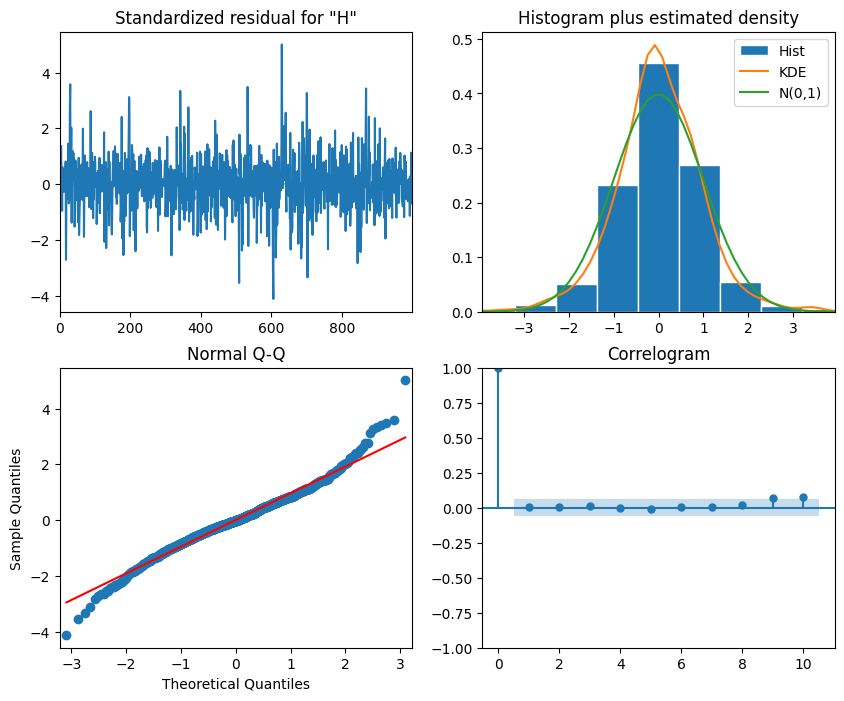

In [79]:
model = SARIMAX(MA_train_diff, order=(24,0,8), simple_differencing=False)
model_fit = model.fit(disp=False)
model_fit.plot_diagnostics(figsize=(10, 8))
plt.show()

In [80]:
residuals = model_fit.resid
sm.stats.acorr_ljungbox(residuals, np.arange(1, 11, 1), return_df=True)

,lb_stat,lb_pvalue
1,0.190817,0.662237
2,0.192443,0.908263
3,0.192722,0.978756
4,0.617605,0.961087
5,0.739117,0.980753
6,0.983071,0.986246
7,1.062355,0.993759
8,1.116020,0.997404
9,6.394502,0.699877
10,9.649382,0.471774


In [73]:
pred_ARMA = rolling_forecast(MA_dataset_diff, TRAIN_LEN, HORIZON, WINDOW, 'ARMA')

In [78]:
# pred_df['pred_ARMA'] = pred_ARMA
pred_df.head(10)

,Hourly Demand Met (in MW) diff,pred_mean,pred_last_value,pred_MA,pred_AR,pred_ARMA
1000,649.99,23.064500,246.53,177.581668,1074.426401,971.942529
1001,3794.75,23.690799,649.99,539.360638,3766.858186,3751.519687
1002,2548.86,27.454331,3794.75,4193.832489,2566.126549,2566.174898
1003,-6973.44,29.968195,2548.86,515.646830,-4838.635282,-4925.362449
1004,-4028.92,22.992689,-6973.44,-9131.397540,-6225.871023,-6099.590802
1005,-4238.26,18.960935,-4028.92,217.088878,-5032.496117,-5055.320134
1006,-4919.37,14.729105,-4238.26,-3420.698607,-4103.049138,-4342.012265
1007,-4462.51,9.829305,-4919.37,-3578.422525,-4496.444156,-4655.098708
1008,-3070.47,5.392460,-4462.51,-3157.947990,-2670.251917,-2600.246868
1009,-1298.93,2.344034,-3070.47,-883.789579,-1578.354737,-1463.151348


In [76]:
mse_ARMA = mean_squared_error(pred_df['Hourly Demand Met (in MW) diff'], pred_df['pred_ARMA'])
mse_ARMA

np.float64(817721.1089540538)

In [83]:
mse_ARMA = mape(pred_df['Hourly Demand Met (in MW) diff'], pred_df['pred_ARMA'])
mse_ARMA

np.float64(-0.28989280161837794)

In [92]:
MA_dataset = dataset['Hourly Demand Met (in MW)'][0:1101]
MA_dataset.head()

0    108985.17
1    105856.08
2    103115.75
3    102407.04
4    104235.34
Name: Hourly Demand Met (in MW), dtype: float64

In [113]:
MA_dataset = dataset['Hourly Demand Met (in MW)'][0:1100].copy()
MA_dataset.tail()

1095    132542.36
1096    133728.64
1097    134944.64
1098    139884.54
1099    141681.55
Name: Hourly Demand Met (in MW), dtype: float64

In [114]:
MA_dataset = pd.DataFrame(MA_dataset, columns = ['Hourly Demand Met (in MW)'])
MA_dataset

,Hourly Demand Met (in MW)
0,108985.17
1,105856.08
2,103115.75
3,102407.04
4,104235.34
...,...
1095,132542.36
1096,133728.64
1097,134944.64
1098,139884.54


In [115]:
pred_df.shape, MA_dataset.shape

((100, 6), (1100, 1))

In [116]:
MA_dataset.loc[1000:, 'pred_demand'] = (
    MA_dataset['Hourly Demand Met (in MW)'].iloc[1000] + pred_df['pred_ARMA'].cumsum().values
)

In [118]:
MA_dataset[1000:]

,Hourly Demand Met (in MW),pred_demand
1000,132049.67,133021.612529
1001,132699.66,136773.132216
1002,136494.41,139339.307114
1003,139043.27,134413.944665
1004,132069.83,128314.353863
...,...,...
1095,132542.36,132373.367425
1096,133728.64,133677.800311
1097,134944.64,137801.460954
1098,139884.54,140362.450357


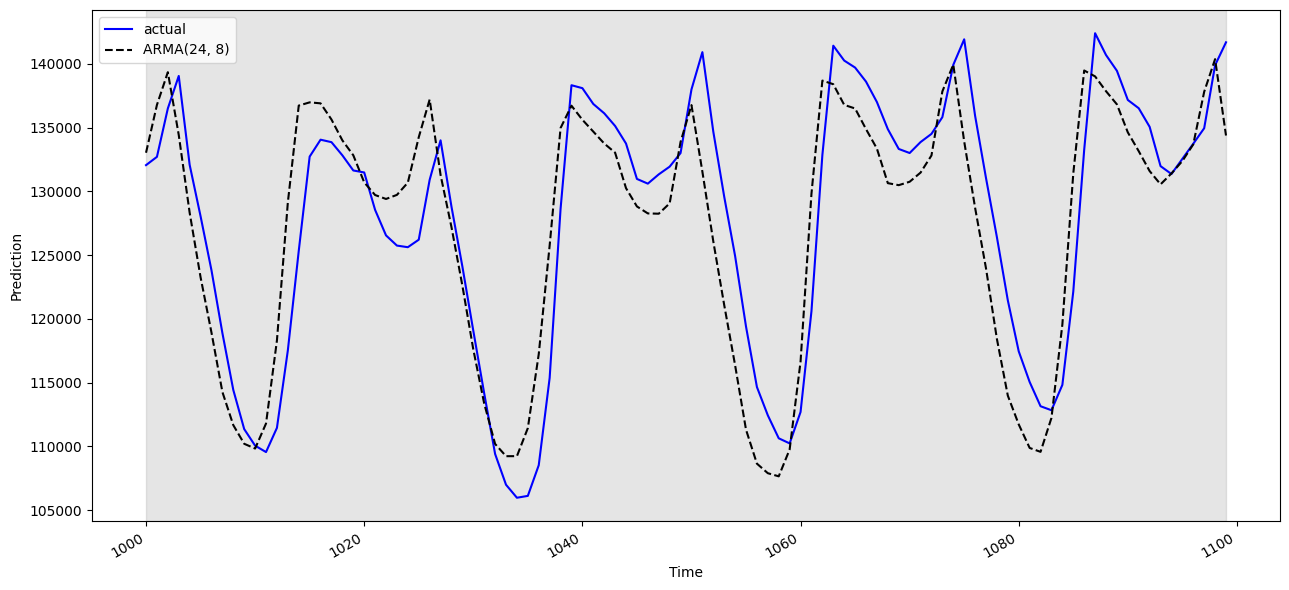

In [121]:
fig, ax = plt.subplots(figsize = (13, 6))
ax.plot(MA_dataset['Hourly Demand Met (in MW)'][1000:], 'b-', label='actual')
ax.plot(MA_dataset['pred_demand'], 'k--', label='ARMA(24, 8)')
ax.legend(loc=2)
ax.set_xlabel('Time')
ax.set_ylabel('Prediction')
ax.axvspan(1000, 1099, color='#808080', alpha=0.2)
# ax.set_xlim(400, 500)
# plt.xticks(
# [409, 439, 468, 498],
# ['Mar', 'Apr', 'May', 'Jun'])
fig.autofmt_xdate()
plt.tight_layout()

In [ ]:
# Initialize plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))

# Data for the plot
x = ['Baseline MAPE', 'Last Hour MAPE', 'Last Season MAPE', ]
y = [mse_mean, mse_last, mse_MA]

# Create a bar plot
ax.bar(x, y, color=['skyblue', 'orange', 'green'])
ax.set_xlabel('Methods', fontsize=12)
ax.set_ylabel('MAPE (Value)', fontsize=12)
ax.set_ylim(0, max(y) * 1.2)  # Dynamically set y-axis limit
ax.set_title('Comparison of MAPE Across Methods', fontsize=14)

# Annotate the bar plot with values
for index, value in enumerate(y):
    ax.text(index, value + (max(y) * 0.05), s=f"{value:.2f}", ha='center', fontsize=10)

# Adjust layout and show plot
plt.tight_layout()
plt.show()